In [1]:
import zuko
from zuko.bayesian import BayesianModel
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
# ------------------
data_path = "/eos/user/d/dvalsecc/uncertainties_flows_paper/500k_2d_gaussian_heavy_tail_target_set.npy"
target_data = np.load(data_path) #load data from generate_target_data.py 
target_tensor = torch.from_numpy(target_data)

In [3]:
target_tensor[:, 0] = (target_tensor[:, 0 ] +0.5) *6
target_tensor[:, 1] = target_tensor[:, 1 ] *2.5 - 5


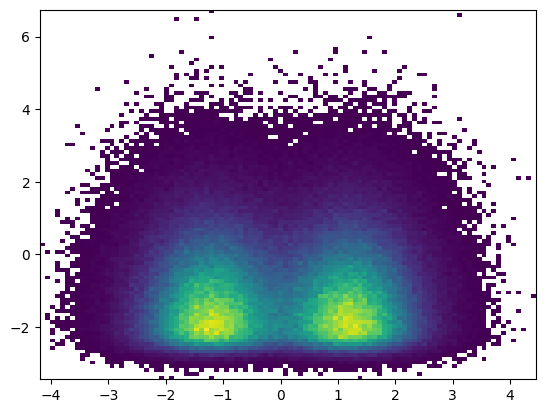

In [170]:
plt.hist2d(target_tensor[:,0], target_tensor[:,1], bins=100, cmin=1);

In [52]:
from torch.utils.data import DataLoader, TensorDataset, random_split
dataset =  TensorDataset(target_tensor.to("cuda"))
train_ds , val_ds = random_split(dataset, [0.9,0.1])
train_loader = DataLoader(
        train_ds,
        batch_size=256,
        shuffle=True,
        pin_memory=False,
    )
val_loader = DataLoader(
        val_ds,
        batch_size=4096,
        shuffle=True,
        pin_memory=False,
    )

In [25]:
def train_flow(model,  train_data, val_data, optimizer,  scheduler, batch_size, epochs, steps=1000,  niter_plot = None, niter_print=500):
    val_losses = []
    
    N_train_events = len(train_data.dataset)

    for epoch in range(epochs):
        model.current_epoch = epoch
        model.train()
        train_loss = 0.
        
        for batch_idx, X in enumerate(train_data):
            optimizer.zero_grad()
            
            with model.reparameterize(local_trick=True) as bmodel:
                log_prob = bmodel().log_prob(X[0])
            
            kl = model.kl_divergence()/N_train_events
            loss = - log_prob.mean() +  kl
        
            train_loss += loss.item()    
            
            if batch_idx % niter_print == 0:
                print(f"epoch {epoch}, step {batch_idx}/{steps}, Loss: {loss.item():.4f}, KL loss: {kl.item():.4f}")
                 
            loss.backward() 
            optimizer.step()
            scheduler.step()
            if niter_plot:
                if batch_idx == niter_plot:
                    break

        train_loss /= (batch_idx+1)
        
    
        val_loss = 0.  
        with torch.no_grad():
            for X in val_data:
                bmodel = model.sample_model()
                log_probval = bmodel().log_prob(X[0])
                val_loss = -log_probval.mean()
            
            print(f"epoch {epoch}, Validation Loss: {val_loss:.4f}")

        with torch.no_grad():
            bmodel = bayes_model.sample_model()
            y = bmodel().rsample((len(target_data),))
            
        fig = plt.figure(figsize=(12,6))
        plt.subplot(1,2,1)
        plt.hist(y.cpu()[:,0], bins=100, range=(-5,5));
        plt.hist(target_data[:,0], bins=100, range=(-5,5),histtype="step", linewidth=2);

        plt.subplot(1,2,2)
        plt.hist(y.cpu()[:,1], bins=100, range=(-5,5));
        plt.hist(target_data[:,1], bins=100, range=(-5,5),histtype="step", linewidth=2);
        plt.show()


        #scheduler.step(val_loss)
        val_losses.append(val_loss)
        #exp.log_metric("loss_val", val_loss, epoch=epoch)
            
        print(f"End of epoch {epoch}")
    return model, val_losses



In [26]:
from torch.optim.lr_scheduler import _LRScheduler, LambdaLR
import math
# Define the warmup + cosine decay function
def LinearWarmupCosineDecay(optimizer, warmup_steps, total_steps):
    def lr_lambda(current_step):
        # If before or within warmup, do linear warmup (inclusive of step==warmup_steps -> 1.0)
        if current_step <= warmup_steps:
            # Linear warmup from 0 -> 1 over warmup_steps
            return float(current_step) / float(max(1, warmup_steps))

        # After warmup, for steps up to total_steps use cosine decay from 1 -> 0.
        # For any step >= total_steps we must not let the lr go back up: clamp to 0.0
        if current_step >= total_steps:
            return 1e-8

        # Cosine decay in (warmup_steps, total_steps)
        progress = (current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        # cosine goes from 1 -> 0 as progress goes 0 -> 1
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return LambdaLR(optimizer, lr_lambda)

epoch 0, step 0/1757, Loss: 3.9505, KL loss: 0.0511
epoch 0, step 200/1757, Loss: 4.0210, KL loss: 0.0511
epoch 0, step 400/1757, Loss: 3.9093, KL loss: 0.0511
epoch 0, step 600/1757, Loss: 3.5781, KL loss: 0.0511
epoch 0, step 800/1757, Loss: 3.2981, KL loss: 0.0511
epoch 0, step 1000/1757, Loss: 3.2994, KL loss: 0.0510
epoch 0, step 1200/1757, Loss: 3.1544, KL loss: 0.0510
epoch 0, step 1400/1757, Loss: 3.1779, KL loss: 0.0510
epoch 0, step 1600/1757, Loss: 3.0822, KL loss: 0.0509
epoch 0, Validation Loss: 3.1469


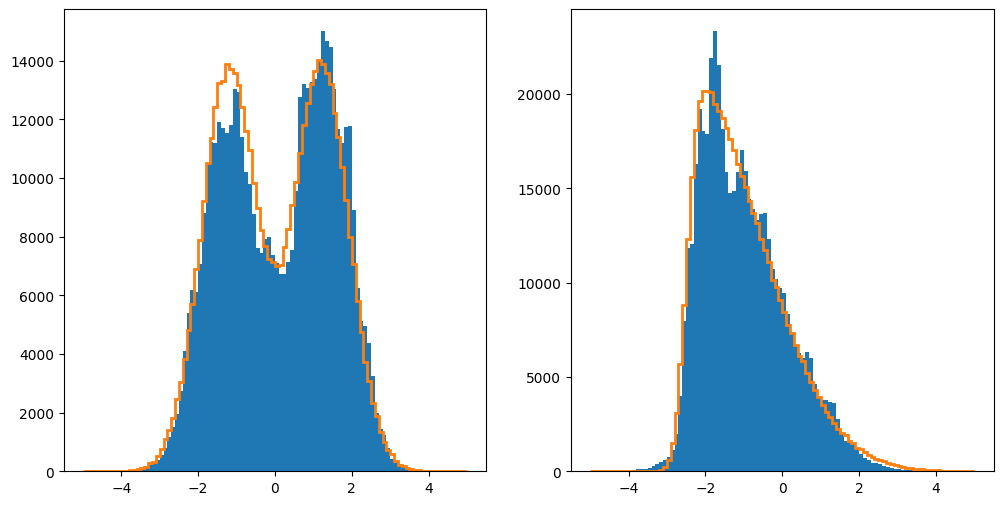

End of epoch 0
epoch 1, step 0/1757, Loss: 3.2301, KL loss: 0.0509
epoch 1, step 200/1757, Loss: 3.1679, KL loss: 0.0509
epoch 1, step 400/1757, Loss: 3.1006, KL loss: 0.0508
epoch 1, step 600/1757, Loss: 3.1957, KL loss: 0.0508
epoch 1, step 800/1757, Loss: 3.1334, KL loss: 0.0507
epoch 1, step 1000/1757, Loss: 3.1868, KL loss: 0.0507
epoch 1, step 1200/1757, Loss: 3.1047, KL loss: 0.0506
epoch 1, step 1400/1757, Loss: 3.0941, KL loss: 0.0506
epoch 1, step 1600/1757, Loss: 3.2284, KL loss: 0.0505
epoch 1, Validation Loss: 3.1538


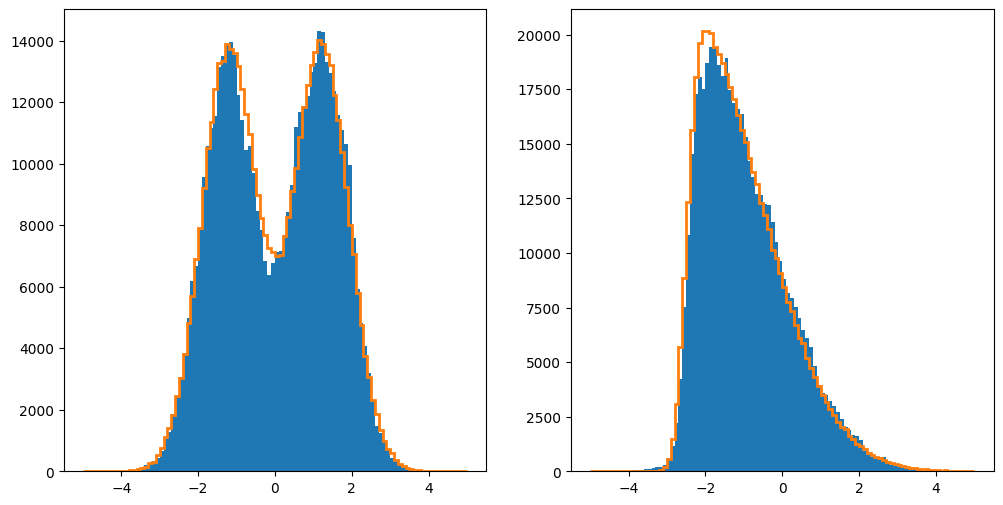

End of epoch 1
epoch 2, step 0/1757, Loss: 3.1620, KL loss: 0.0505
epoch 2, step 200/1757, Loss: 3.0835, KL loss: 0.0504
epoch 2, step 400/1757, Loss: 3.1574, KL loss: 0.0504
epoch 2, step 600/1757, Loss: 3.2427, KL loss: 0.0503
epoch 2, step 800/1757, Loss: 3.1737, KL loss: 0.0503
epoch 2, step 1000/1757, Loss: 3.0995, KL loss: 0.0502
epoch 2, step 1200/1757, Loss: 3.1746, KL loss: 0.0502
epoch 2, step 1400/1757, Loss: 3.2259, KL loss: 0.0501
epoch 2, step 1600/1757, Loss: 3.1130, KL loss: 0.0501
epoch 2, Validation Loss: 3.1068


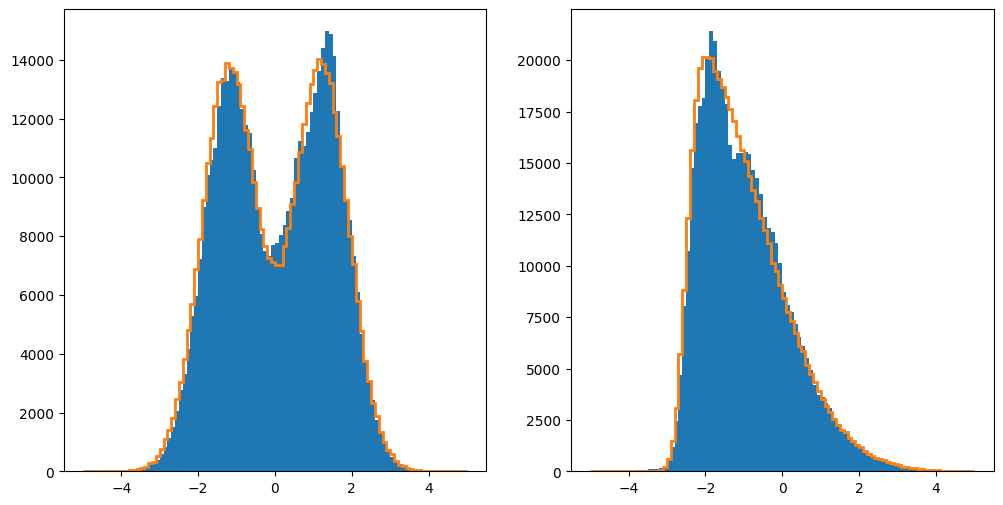

End of epoch 2
epoch 3, step 0/1757, Loss: 3.2639, KL loss: 0.0500
epoch 3, step 200/1757, Loss: 3.0890, KL loss: 0.0500
epoch 3, step 400/1757, Loss: 3.1612, KL loss: 0.0499
epoch 3, step 600/1757, Loss: 3.2092, KL loss: 0.0499
epoch 3, step 800/1757, Loss: 3.0867, KL loss: 0.0498
epoch 3, step 1000/1757, Loss: 3.1486, KL loss: 0.0498
epoch 3, step 1200/1757, Loss: 3.1983, KL loss: 0.0497
epoch 3, step 1400/1757, Loss: 3.1532, KL loss: 0.0497
epoch 3, step 1600/1757, Loss: 3.1731, KL loss: 0.0496
epoch 3, Validation Loss: 3.0378


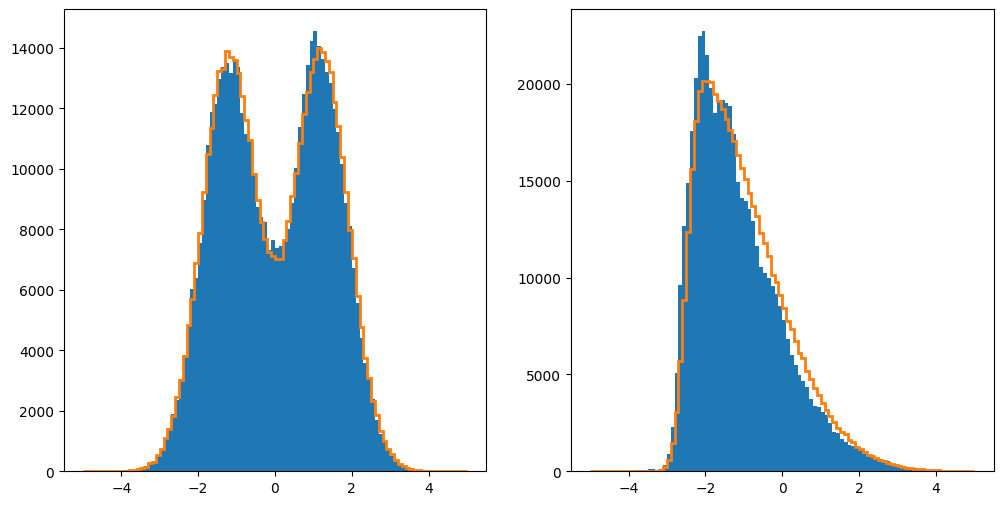

End of epoch 3
epoch 4, step 0/1757, Loss: 3.2251, KL loss: 0.0496
epoch 4, step 200/1757, Loss: 3.1686, KL loss: 0.0495
epoch 4, step 400/1757, Loss: 3.2105, KL loss: 0.0495
epoch 4, step 600/1757, Loss: 3.1828, KL loss: 0.0494
epoch 4, step 800/1757, Loss: 3.1112, KL loss: 0.0494
epoch 4, step 1000/1757, Loss: 3.1231, KL loss: 0.0493
epoch 4, step 1200/1757, Loss: 3.1114, KL loss: 0.0493
epoch 4, step 1400/1757, Loss: 3.2938, KL loss: 0.0492
epoch 4, step 1600/1757, Loss: 3.3022, KL loss: 0.0492
epoch 4, Validation Loss: 3.1106


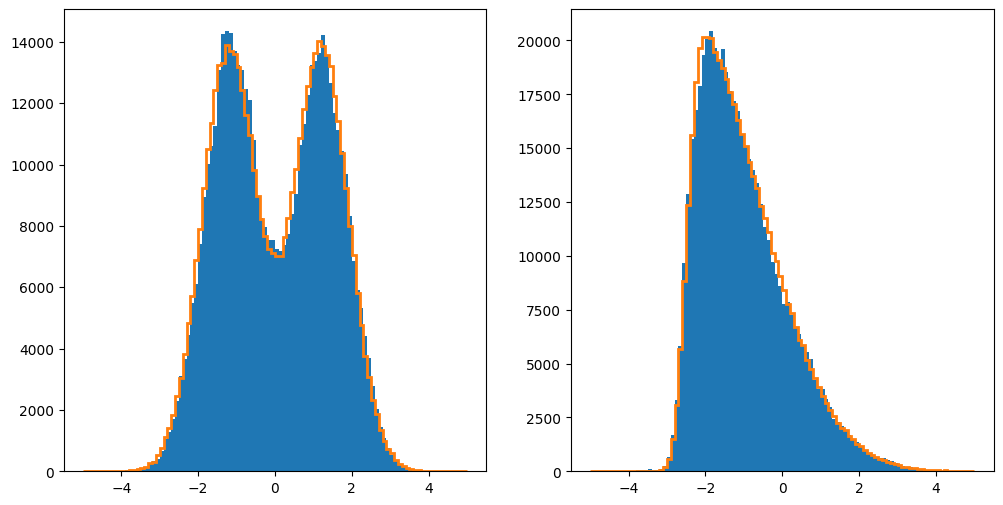

End of epoch 4
epoch 5, step 0/1757, Loss: 3.0891, KL loss: 0.0491
epoch 5, step 200/1757, Loss: 3.2813, KL loss: 0.0491
epoch 5, step 400/1757, Loss: 3.2326, KL loss: 0.0490
epoch 5, step 600/1757, Loss: 3.1115, KL loss: 0.0490
epoch 5, step 800/1757, Loss: 3.2069, KL loss: 0.0489
epoch 5, step 1000/1757, Loss: 3.1358, KL loss: 0.0489
epoch 5, step 1200/1757, Loss: 3.1904, KL loss: 0.0488
epoch 5, step 1400/1757, Loss: 3.1168, KL loss: 0.0488
epoch 5, step 1600/1757, Loss: 3.2040, KL loss: 0.0487
epoch 5, Validation Loss: 3.1248


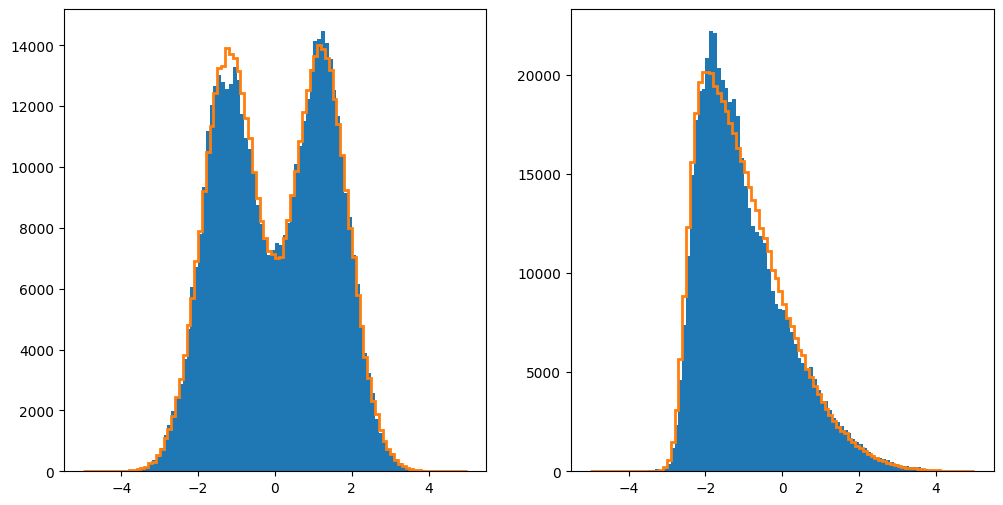

End of epoch 5
epoch 6, step 0/1757, Loss: 3.1409, KL loss: 0.0487
epoch 6, step 200/1757, Loss: 3.2784, KL loss: 0.0486
epoch 6, step 400/1757, Loss: 3.0775, KL loss: 0.0486
epoch 6, step 600/1757, Loss: 3.2737, KL loss: 0.0485
epoch 6, step 800/1757, Loss: 3.2208, KL loss: 0.0484
epoch 6, step 1000/1757, Loss: 3.1385, KL loss: 0.0484
epoch 6, step 1200/1757, Loss: 3.2173, KL loss: 0.0483
epoch 6, step 1400/1757, Loss: 3.1557, KL loss: 0.0483
epoch 6, step 1600/1757, Loss: 3.1798, KL loss: 0.0482
epoch 6, Validation Loss: 3.1055


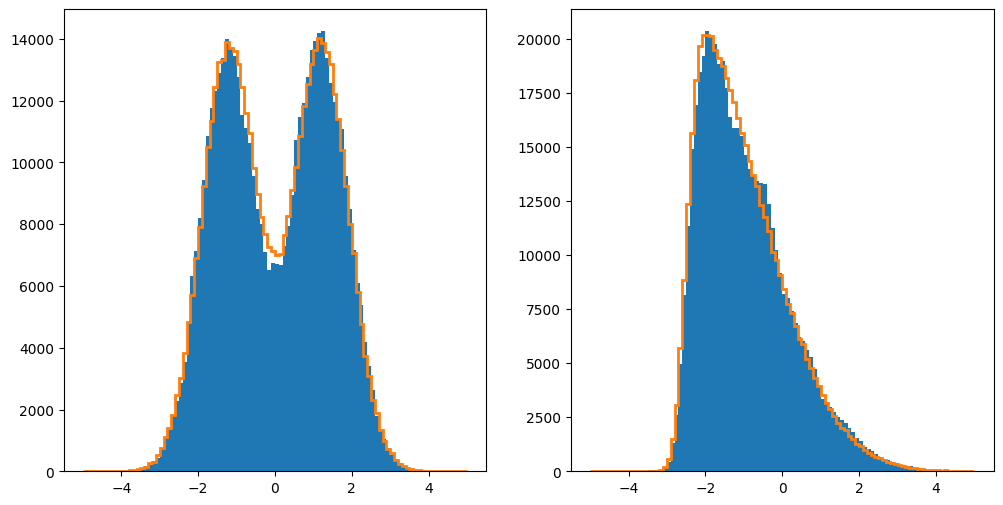

End of epoch 6
epoch 7, step 0/1757, Loss: 3.1919, KL loss: 0.0482
epoch 7, step 200/1757, Loss: 3.0719, KL loss: 0.0481
epoch 7, step 400/1757, Loss: 3.1335, KL loss: 0.0481
epoch 7, step 600/1757, Loss: 3.1846, KL loss: 0.0480
epoch 7, step 800/1757, Loss: 3.1605, KL loss: 0.0480
epoch 7, step 1000/1757, Loss: 3.1422, KL loss: 0.0479
epoch 7, step 1200/1757, Loss: 3.2291, KL loss: 0.0479
epoch 7, step 1400/1757, Loss: 3.2079, KL loss: 0.0478
epoch 7, step 1600/1757, Loss: 3.0718, KL loss: 0.0478
epoch 7, Validation Loss: 3.1877


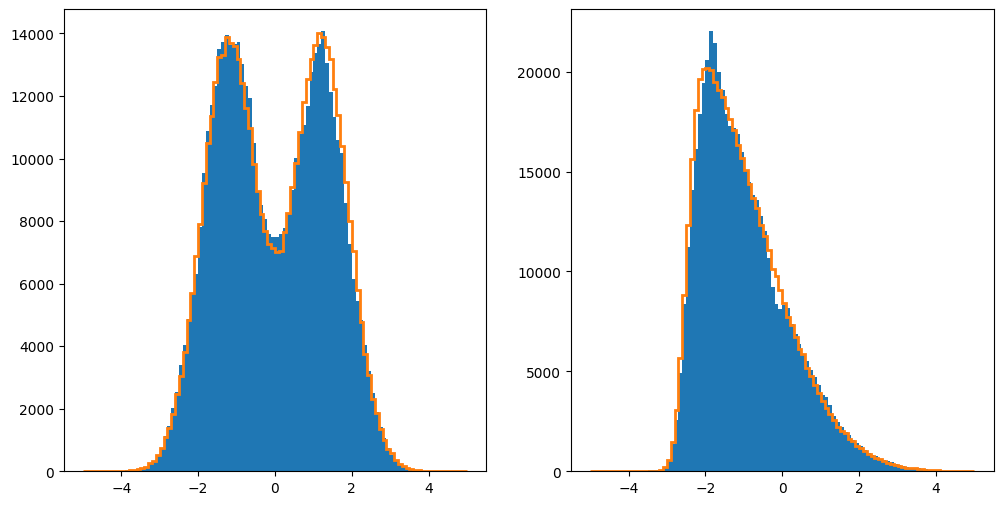

End of epoch 7
epoch 8, step 0/1757, Loss: 3.2017, KL loss: 0.0477
epoch 8, step 200/1757, Loss: 3.1337, KL loss: 0.0477
epoch 8, step 400/1757, Loss: 3.2267, KL loss: 0.0476
epoch 8, step 600/1757, Loss: 3.1042, KL loss: 0.0476
epoch 8, step 800/1757, Loss: 3.1930, KL loss: 0.0475
epoch 8, step 1000/1757, Loss: 3.2746, KL loss: 0.0475
epoch 8, step 1200/1757, Loss: 3.0856, KL loss: 0.0474
epoch 8, step 1400/1757, Loss: 3.2156, KL loss: 0.0474
epoch 8, step 1600/1757, Loss: 3.1839, KL loss: 0.0473
epoch 8, Validation Loss: 3.1065


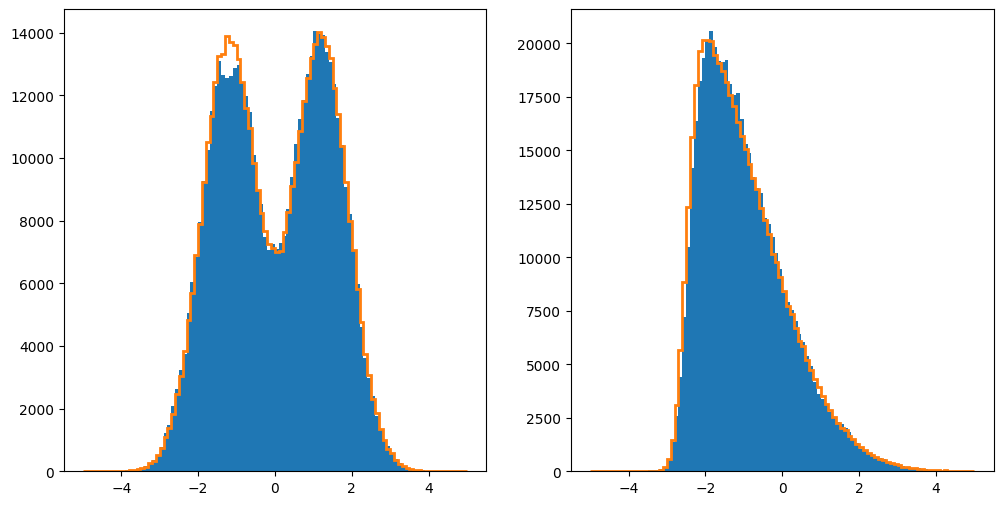

End of epoch 8
epoch 9, step 0/1757, Loss: 3.0343, KL loss: 0.0473
epoch 9, step 200/1757, Loss: 3.1441, KL loss: 0.0473
epoch 9, step 400/1757, Loss: 3.1562, KL loss: 0.0472
epoch 9, step 600/1757, Loss: 3.1145, KL loss: 0.0472
epoch 9, step 800/1757, Loss: 3.1441, KL loss: 0.0471
epoch 9, step 1000/1757, Loss: 3.1399, KL loss: 0.0471
epoch 9, step 1200/1757, Loss: 3.1736, KL loss: 0.0470
epoch 9, step 1400/1757, Loss: 3.1878, KL loss: 0.0470
epoch 9, step 1600/1757, Loss: 3.2279, KL loss: 0.0469
epoch 9, Validation Loss: 3.1248


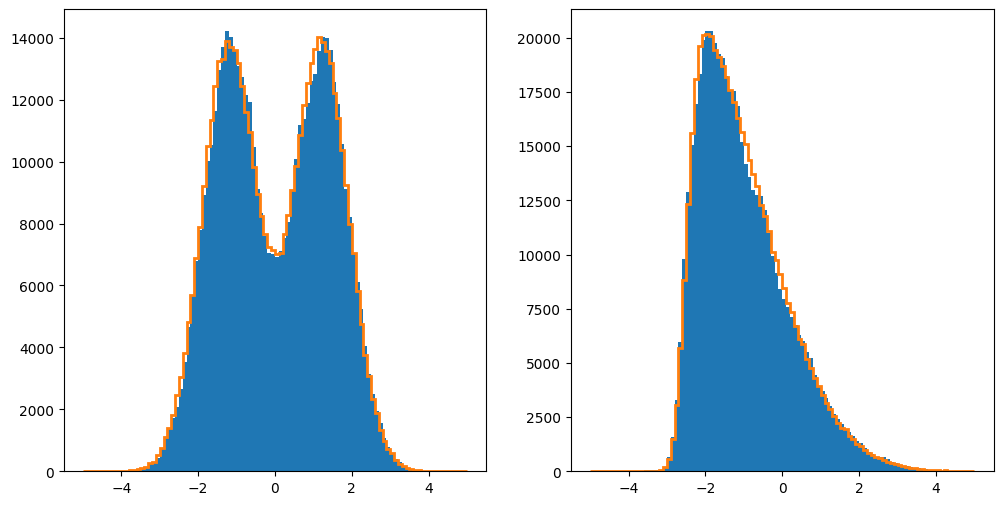

End of epoch 9
epoch 10, step 0/1757, Loss: 3.1777, KL loss: 0.0469
epoch 10, step 200/1757, Loss: 3.1612, KL loss: 0.0468
epoch 10, step 400/1757, Loss: 3.1680, KL loss: 0.0468
epoch 10, step 600/1757, Loss: 3.1514, KL loss: 0.0467
epoch 10, step 800/1757, Loss: 3.1768, KL loss: 0.0467
epoch 10, step 1000/1757, Loss: 3.2115, KL loss: 0.0467
epoch 10, step 1200/1757, Loss: 3.2386, KL loss: 0.0466
epoch 10, step 1400/1757, Loss: 3.2735, KL loss: 0.0466
epoch 10, step 1600/1757, Loss: 3.1173, KL loss: 0.0465
epoch 10, Validation Loss: 3.1263


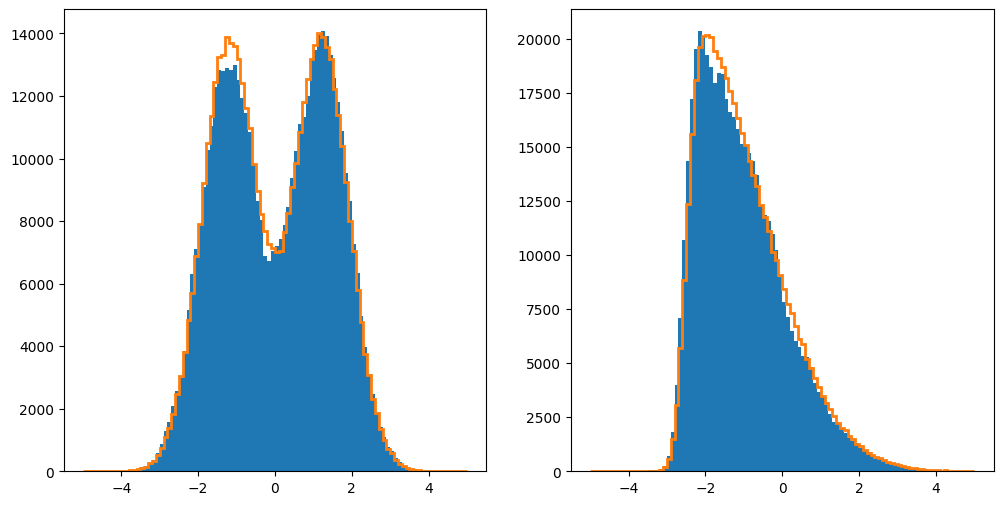

End of epoch 10
epoch 11, step 0/1757, Loss: 3.0560, KL loss: 0.0465
epoch 11, step 200/1757, Loss: 3.0768, KL loss: 0.0464
epoch 11, step 400/1757, Loss: 3.1992, KL loss: 0.0464
epoch 11, step 600/1757, Loss: 3.1537, KL loss: 0.0464
epoch 11, step 800/1757, Loss: 3.1859, KL loss: 0.0463
epoch 11, step 1000/1757, Loss: 3.1329, KL loss: 0.0463
epoch 11, step 1200/1757, Loss: 3.1383, KL loss: 0.0462
epoch 11, step 1400/1757, Loss: 3.1799, KL loss: 0.0462
epoch 11, step 1600/1757, Loss: 3.1376, KL loss: 0.0461
epoch 11, Validation Loss: 3.1100


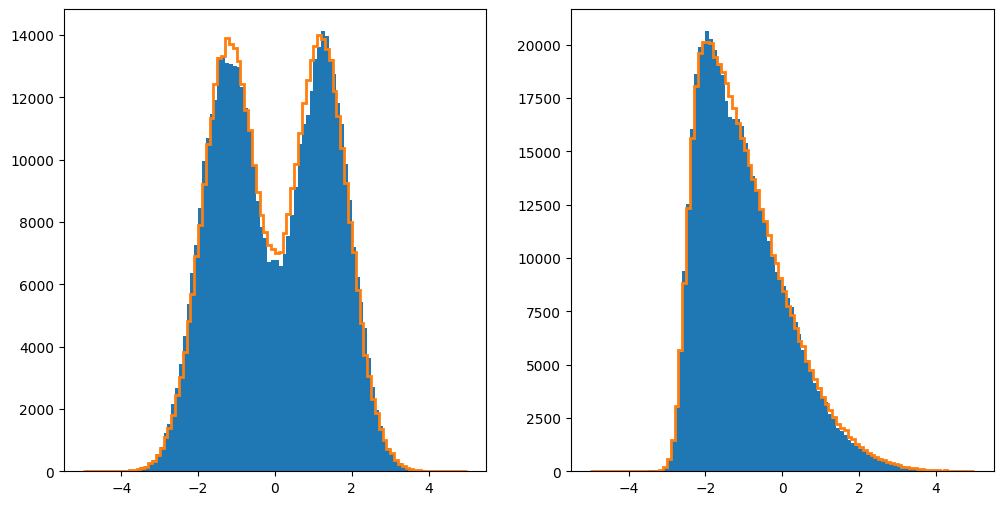

End of epoch 11
epoch 12, step 0/1757, Loss: 3.1661, KL loss: 0.0461
epoch 12, step 200/1757, Loss: 3.1063, KL loss: 0.0461
epoch 12, step 400/1757, Loss: 3.0845, KL loss: 0.0460
epoch 12, step 600/1757, Loss: 3.1421, KL loss: 0.0460
epoch 12, step 800/1757, Loss: 3.1365, KL loss: 0.0459
epoch 12, step 1000/1757, Loss: 3.1735, KL loss: 0.0459
epoch 12, step 1200/1757, Loss: 3.1786, KL loss: 0.0459
epoch 12, step 1400/1757, Loss: 3.1897, KL loss: 0.0458
epoch 12, step 1600/1757, Loss: 3.1266, KL loss: 0.0458
epoch 12, Validation Loss: 3.0901


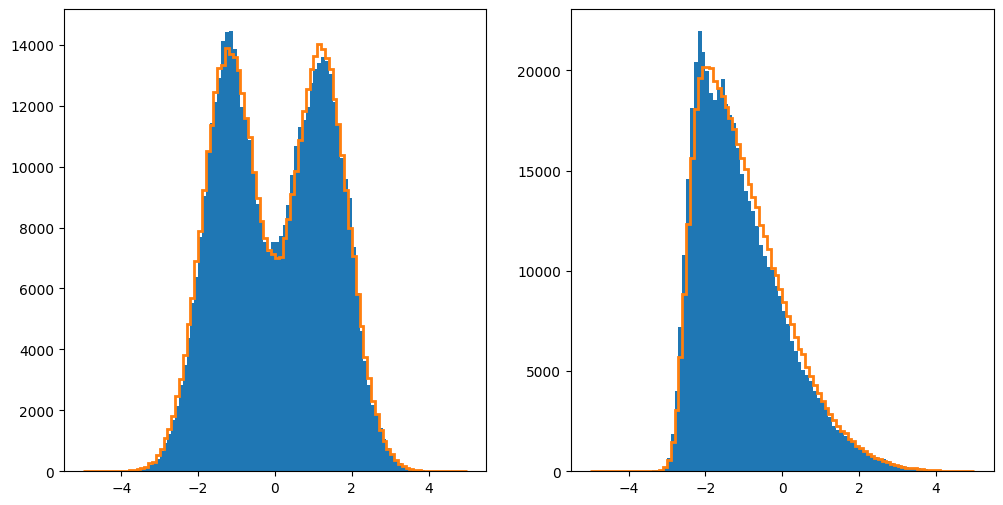

End of epoch 12
epoch 13, step 0/1757, Loss: 3.1363, KL loss: 0.0458
epoch 13, step 200/1757, Loss: 3.1374, KL loss: 0.0457
epoch 13, step 400/1757, Loss: 3.2424, KL loss: 0.0457
epoch 13, step 600/1757, Loss: 3.0936, KL loss: 0.0456
epoch 13, step 800/1757, Loss: 3.1753, KL loss: 0.0456
epoch 13, step 1000/1757, Loss: 3.0661, KL loss: 0.0456
epoch 13, step 1200/1757, Loss: 3.1022, KL loss: 0.0455
epoch 13, step 1400/1757, Loss: 3.1206, KL loss: 0.0455
epoch 13, step 1600/1757, Loss: 3.2090, KL loss: 0.0455
epoch 13, Validation Loss: 3.1012


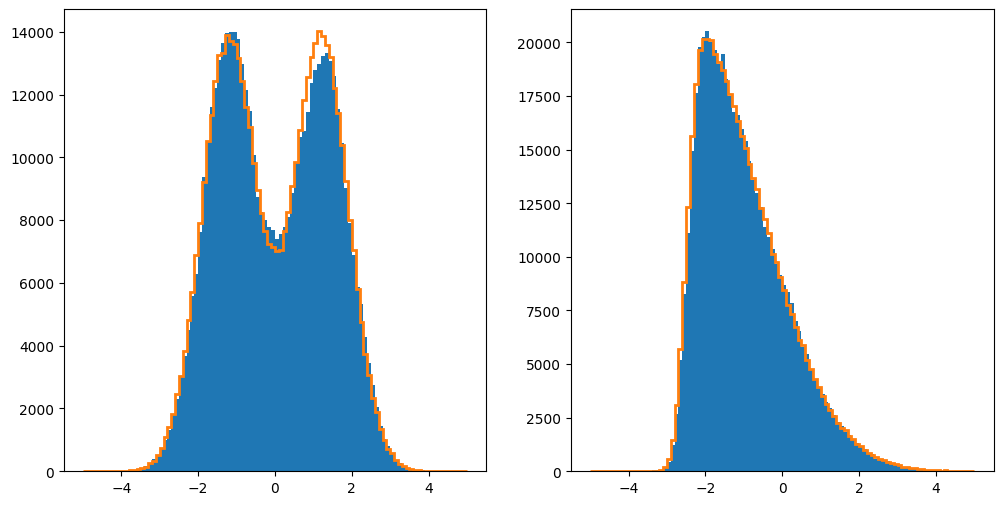

End of epoch 13
epoch 14, step 0/1757, Loss: 3.1116, KL loss: 0.0454
epoch 14, step 200/1757, Loss: 3.1283, KL loss: 0.0454
epoch 14, step 400/1757, Loss: 3.0576, KL loss: 0.0454
epoch 14, step 600/1757, Loss: 3.2137, KL loss: 0.0453
epoch 14, step 800/1757, Loss: 3.1243, KL loss: 0.0453
epoch 14, step 1000/1757, Loss: 3.2035, KL loss: 0.0453
epoch 14, step 1200/1757, Loss: 3.0721, KL loss: 0.0452
epoch 14, step 1400/1757, Loss: 3.2514, KL loss: 0.0452
epoch 14, step 1600/1757, Loss: 3.1777, KL loss: 0.0452
epoch 14, Validation Loss: 3.0709


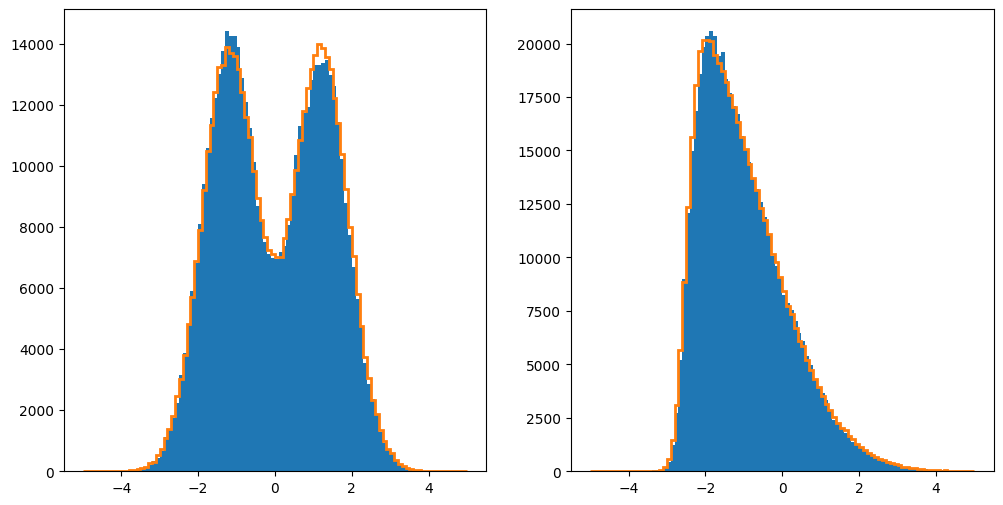

End of epoch 14
epoch 15, step 0/1757, Loss: 3.2387, KL loss: 0.0451
epoch 15, step 200/1757, Loss: 3.0860, KL loss: 0.0451
epoch 15, step 400/1757, Loss: 3.1430, KL loss: 0.0451
epoch 15, step 600/1757, Loss: 3.0931, KL loss: 0.0450
epoch 15, step 800/1757, Loss: 3.1692, KL loss: 0.0450
epoch 15, step 1000/1757, Loss: 3.1121, KL loss: 0.0450
epoch 15, step 1200/1757, Loss: 3.2189, KL loss: 0.0449
epoch 15, step 1400/1757, Loss: 3.2013, KL loss: 0.0449
epoch 15, step 1600/1757, Loss: 3.1712, KL loss: 0.0449
epoch 15, Validation Loss: 3.1333


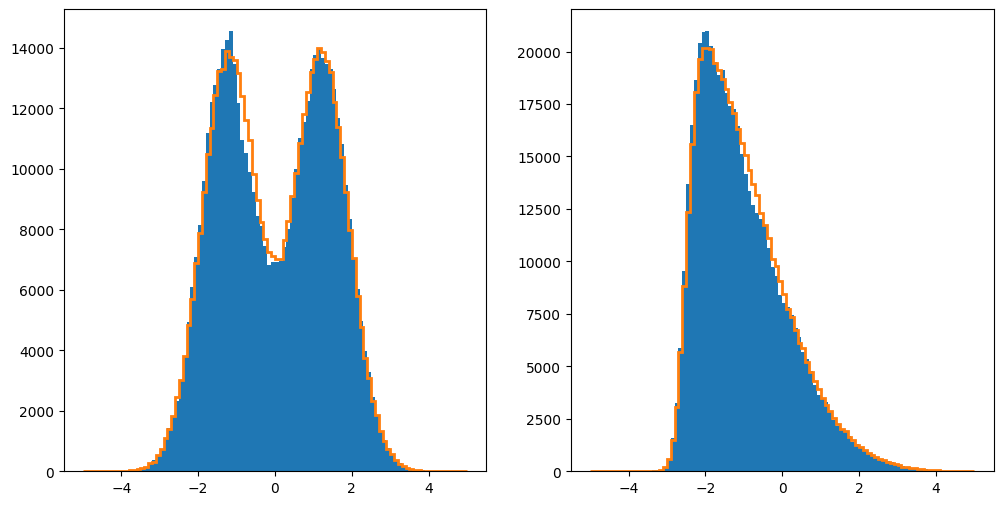

End of epoch 15
epoch 16, step 0/1757, Loss: 3.2165, KL loss: 0.0449
epoch 16, step 200/1757, Loss: 3.1612, KL loss: 0.0448
epoch 16, step 400/1757, Loss: 3.0633, KL loss: 0.0448
epoch 16, step 600/1757, Loss: 3.0826, KL loss: 0.0448
epoch 16, step 800/1757, Loss: 3.2720, KL loss: 0.0447
epoch 16, step 1000/1757, Loss: 3.2348, KL loss: 0.0447
epoch 16, step 1200/1757, Loss: 3.2325, KL loss: 0.0447
epoch 16, step 1400/1757, Loss: 3.1870, KL loss: 0.0447
epoch 16, step 1600/1757, Loss: 3.1749, KL loss: 0.0446
epoch 16, Validation Loss: 3.1460


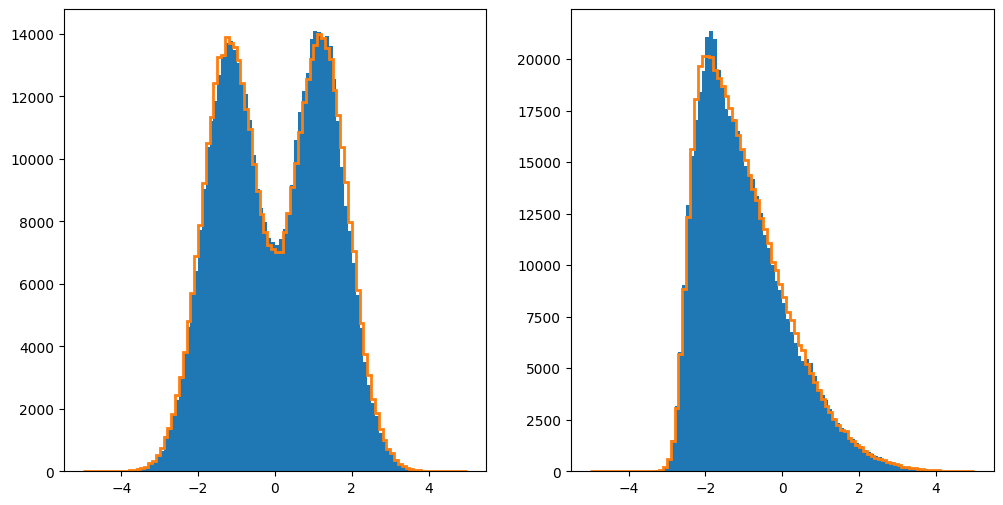

End of epoch 16
epoch 17, step 0/1757, Loss: 3.1067, KL loss: 0.0446
epoch 17, step 200/1757, Loss: 3.1174, KL loss: 0.0446
epoch 17, step 400/1757, Loss: 3.2504, KL loss: 0.0446
epoch 17, step 600/1757, Loss: 3.1030, KL loss: 0.0445
epoch 17, step 800/1757, Loss: 3.1224, KL loss: 0.0445
epoch 17, step 1000/1757, Loss: 3.1139, KL loss: 0.0445
epoch 17, step 1200/1757, Loss: 3.1187, KL loss: 0.0445
epoch 17, step 1400/1757, Loss: 3.1196, KL loss: 0.0444
epoch 17, step 1600/1757, Loss: 3.1673, KL loss: 0.0444
epoch 17, Validation Loss: 3.1546


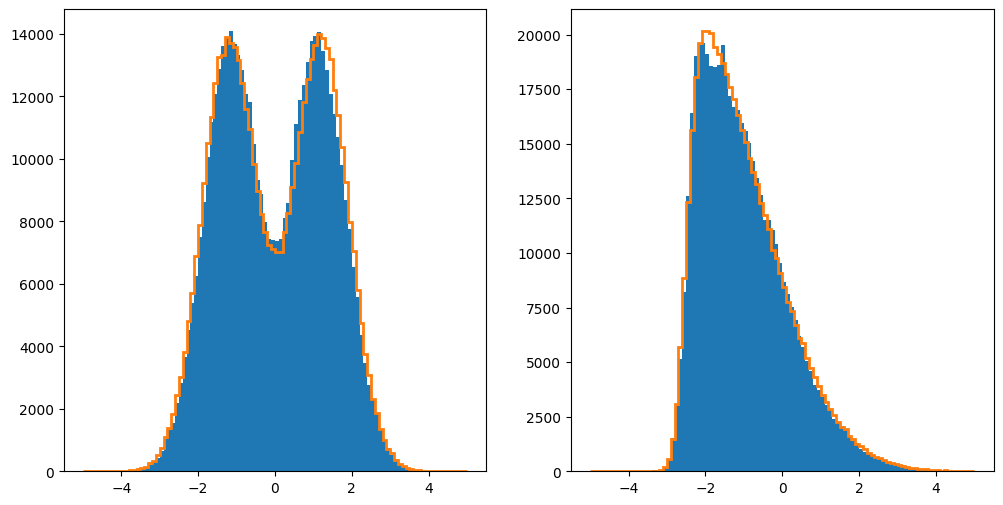

End of epoch 17
epoch 18, step 0/1757, Loss: 3.0930, KL loss: 0.0444
epoch 18, step 200/1757, Loss: 3.2578, KL loss: 0.0444
epoch 18, step 400/1757, Loss: 3.2123, KL loss: 0.0444
epoch 18, step 600/1757, Loss: 3.2358, KL loss: 0.0443
epoch 18, step 800/1757, Loss: 3.1449, KL loss: 0.0443
epoch 18, step 1000/1757, Loss: 3.2311, KL loss: 0.0443
epoch 18, step 1200/1757, Loss: 3.1727, KL loss: 0.0443
epoch 18, step 1400/1757, Loss: 3.1766, KL loss: 0.0442
epoch 18, step 1600/1757, Loss: 3.3127, KL loss: 0.0442
epoch 18, Validation Loss: 3.0354


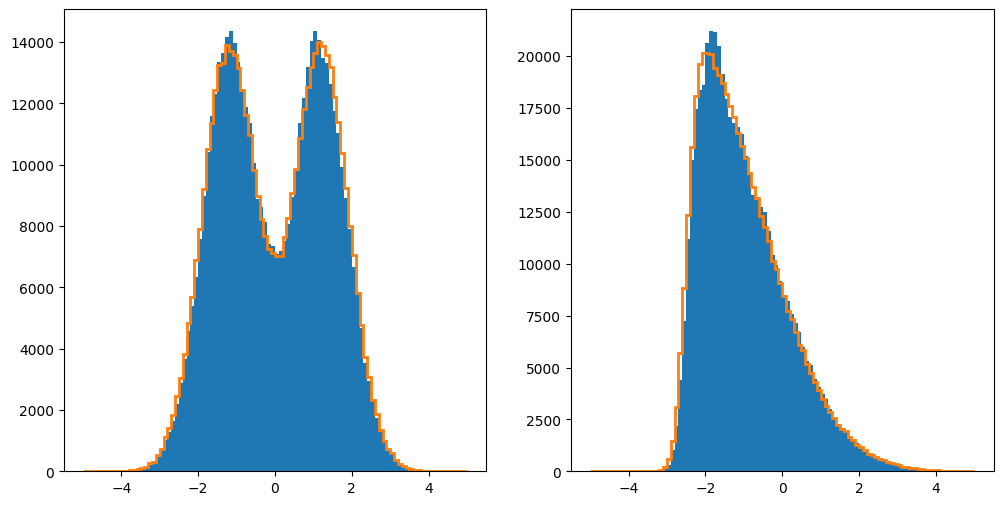

End of epoch 18
epoch 19, step 0/1757, Loss: 3.0434, KL loss: 0.0442
epoch 19, step 200/1757, Loss: 3.0940, KL loss: 0.0442
epoch 19, step 400/1757, Loss: 3.1173, KL loss: 0.0442
epoch 19, step 600/1757, Loss: 3.1864, KL loss: 0.0442
epoch 19, step 800/1757, Loss: 3.2066, KL loss: 0.0441
epoch 19, step 1000/1757, Loss: 3.0553, KL loss: 0.0441
epoch 19, step 1200/1757, Loss: 3.2038, KL loss: 0.0441
epoch 19, step 1400/1757, Loss: 3.0733, KL loss: 0.0441
epoch 19, step 1600/1757, Loss: 3.0962, KL loss: 0.0441
epoch 19, Validation Loss: 3.1335


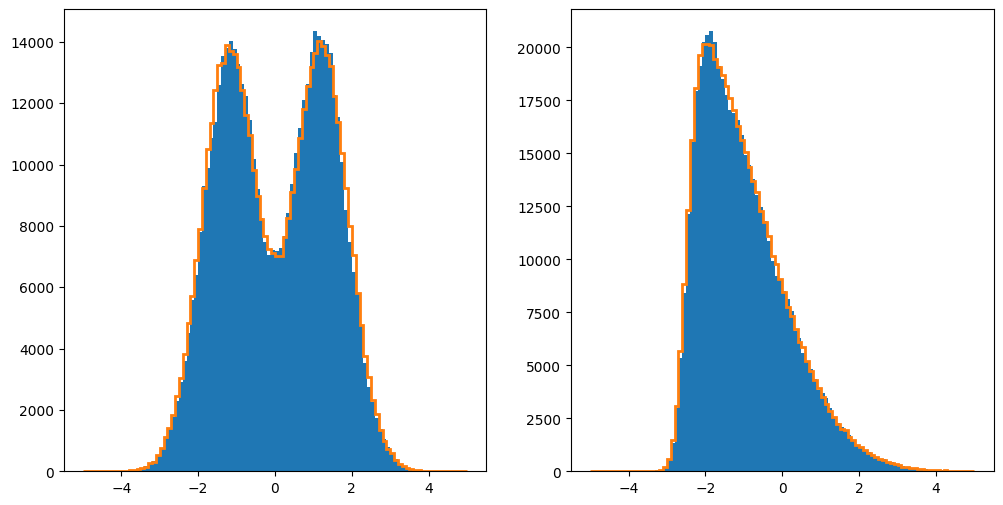

End of epoch 19
epoch 20, step 0/1757, Loss: 3.0807, KL loss: 0.0441
epoch 20, step 200/1757, Loss: 3.1197, KL loss: 0.0440
epoch 20, step 400/1757, Loss: 3.0955, KL loss: 0.0440
epoch 20, step 600/1757, Loss: 3.1366, KL loss: 0.0440
epoch 20, step 800/1757, Loss: 3.1755, KL loss: 0.0440
epoch 20, step 1000/1757, Loss: 3.2202, KL loss: 0.0440
epoch 20, step 1200/1757, Loss: 3.1403, KL loss: 0.0440
epoch 20, step 1400/1757, Loss: 3.1356, KL loss: 0.0440
epoch 20, step 1600/1757, Loss: 3.0844, KL loss: 0.0439
epoch 20, Validation Loss: 3.1862


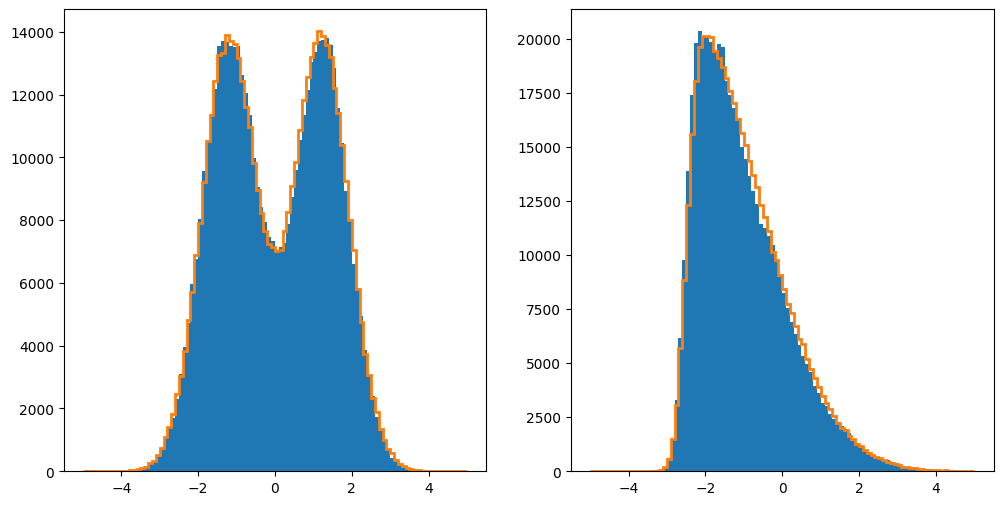

End of epoch 20
epoch 21, step 0/1757, Loss: 3.2097, KL loss: 0.0439
epoch 21, step 200/1757, Loss: 3.1846, KL loss: 0.0439
epoch 21, step 400/1757, Loss: 3.1305, KL loss: 0.0439
epoch 21, step 600/1757, Loss: 3.1762, KL loss: 0.0439
epoch 21, step 800/1757, Loss: 3.1799, KL loss: 0.0439
epoch 21, step 1000/1757, Loss: 3.1174, KL loss: 0.0439
epoch 21, step 1200/1757, Loss: 3.1981, KL loss: 0.0438
epoch 21, step 1400/1757, Loss: 3.1083, KL loss: 0.0438
epoch 21, step 1600/1757, Loss: 3.0773, KL loss: 0.0438
epoch 21, Validation Loss: 3.1083


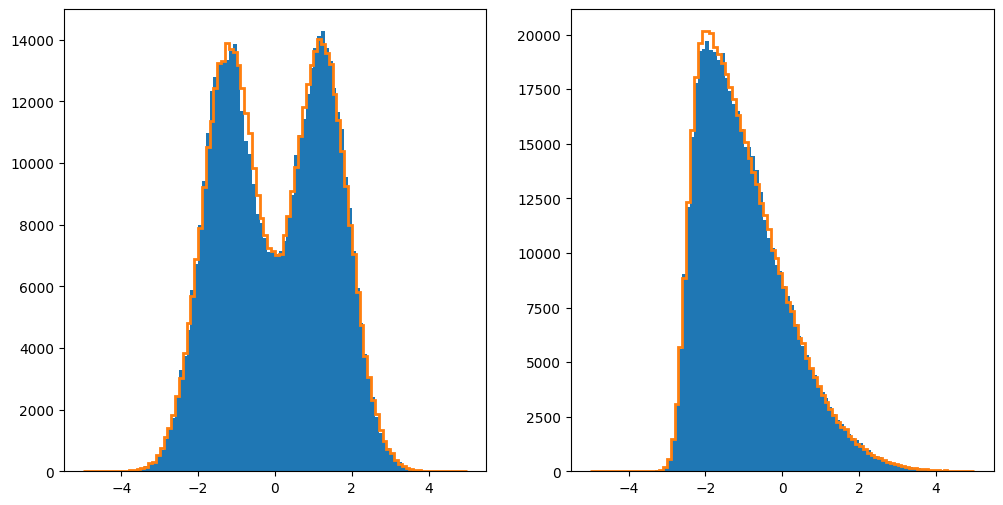

End of epoch 21
epoch 22, step 0/1757, Loss: 3.2337, KL loss: 0.0438
epoch 22, step 200/1757, Loss: 3.1824, KL loss: 0.0438
epoch 22, step 400/1757, Loss: 3.1183, KL loss: 0.0438
epoch 22, step 600/1757, Loss: 3.2101, KL loss: 0.0438
epoch 22, step 800/1757, Loss: 3.1081, KL loss: 0.0438
epoch 22, step 1000/1757, Loss: 3.1399, KL loss: 0.0438
epoch 22, step 1200/1757, Loss: 3.2348, KL loss: 0.0438
epoch 22, step 1400/1757, Loss: 3.1377, KL loss: 0.0437
epoch 22, step 1600/1757, Loss: 3.2064, KL loss: 0.0437
epoch 22, Validation Loss: 3.1603


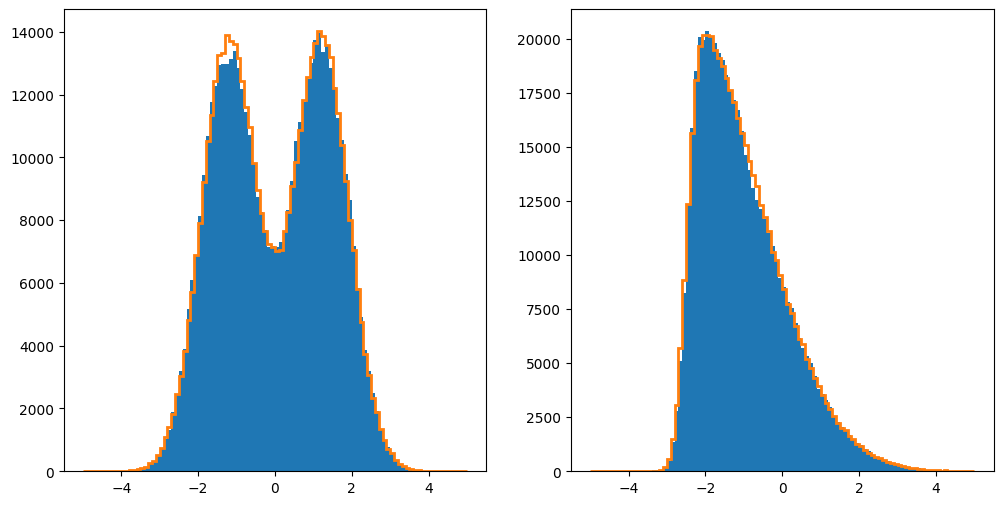

End of epoch 22
epoch 23, step 0/1757, Loss: 3.0770, KL loss: 0.0437
epoch 23, step 200/1757, Loss: 3.1496, KL loss: 0.0437
epoch 23, step 400/1757, Loss: 3.1469, KL loss: 0.0437
epoch 23, step 600/1757, Loss: 3.1983, KL loss: 0.0437
epoch 23, step 800/1757, Loss: 3.1786, KL loss: 0.0437
epoch 23, step 1000/1757, Loss: 3.1115, KL loss: 0.0437
epoch 23, step 1200/1757, Loss: 3.1655, KL loss: 0.0437
epoch 23, step 1400/1757, Loss: 3.1216, KL loss: 0.0437
epoch 23, step 1600/1757, Loss: 3.1873, KL loss: 0.0437
epoch 23, Validation Loss: 3.0600


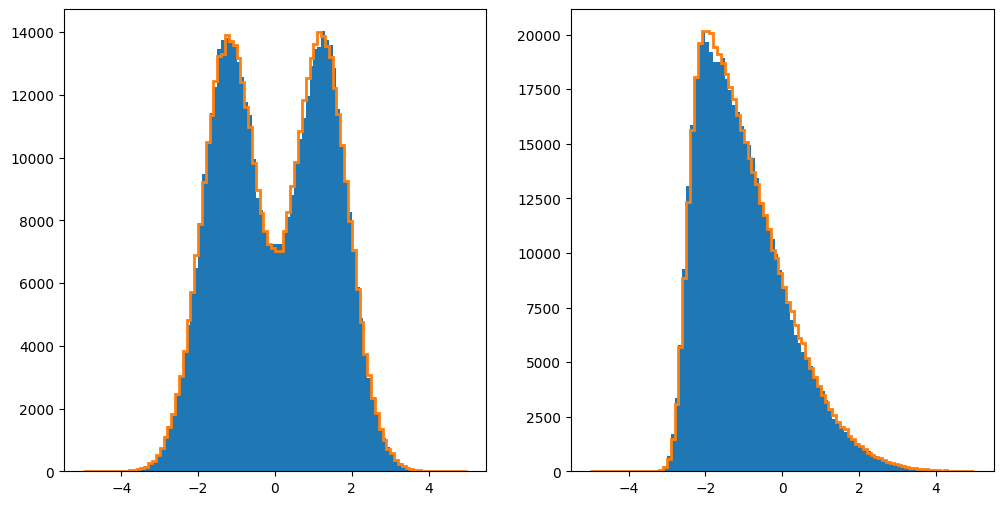

End of epoch 23
epoch 24, step 0/1757, Loss: 3.2409, KL loss: 0.0437
epoch 24, step 200/1757, Loss: 3.1157, KL loss: 0.0437
epoch 24, step 400/1757, Loss: 3.1126, KL loss: 0.0437
epoch 24, step 600/1757, Loss: 3.1347, KL loss: 0.0436
epoch 24, step 800/1757, Loss: 3.2757, KL loss: 0.0436
epoch 24, step 1000/1757, Loss: 3.1372, KL loss: 0.0436
epoch 24, step 1200/1757, Loss: 3.2308, KL loss: 0.0436
epoch 24, step 1400/1757, Loss: 3.1217, KL loss: 0.0436
epoch 24, step 1600/1757, Loss: 3.1142, KL loss: 0.0436
epoch 24, Validation Loss: 3.0792


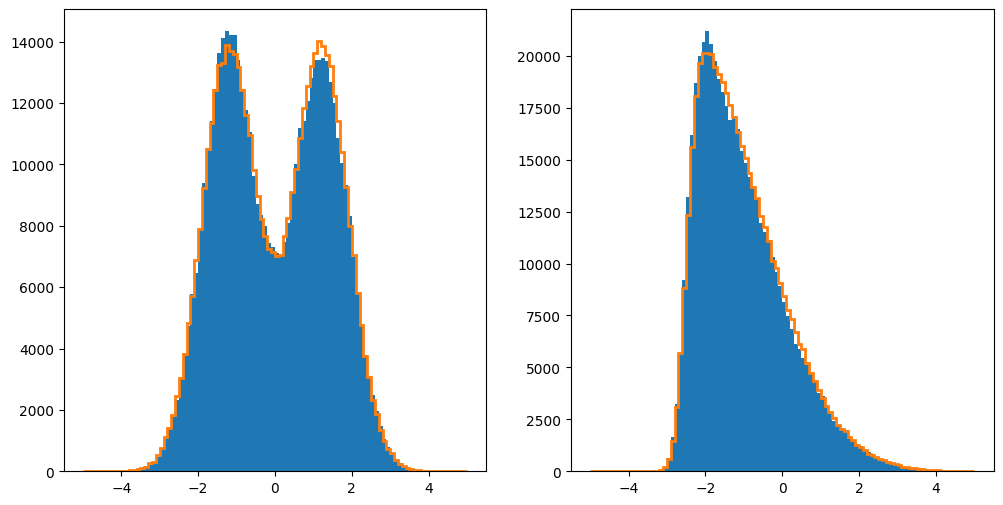

End of epoch 24
epoch 25, step 0/1757, Loss: 3.1369, KL loss: 0.0436
epoch 25, step 200/1757, Loss: 3.1432, KL loss: 0.0436
epoch 25, step 400/1757, Loss: 3.0252, KL loss: 0.0436
epoch 25, step 600/1757, Loss: 3.0524, KL loss: 0.0436
epoch 25, step 800/1757, Loss: 3.1408, KL loss: 0.0436
epoch 25, step 1000/1757, Loss: 3.1217, KL loss: 0.0436
epoch 25, step 1200/1757, Loss: 3.0828, KL loss: 0.0436
epoch 25, step 1400/1757, Loss: 3.1141, KL loss: 0.0436
epoch 25, step 1600/1757, Loss: 3.1651, KL loss: 0.0436
epoch 25, Validation Loss: 3.0928


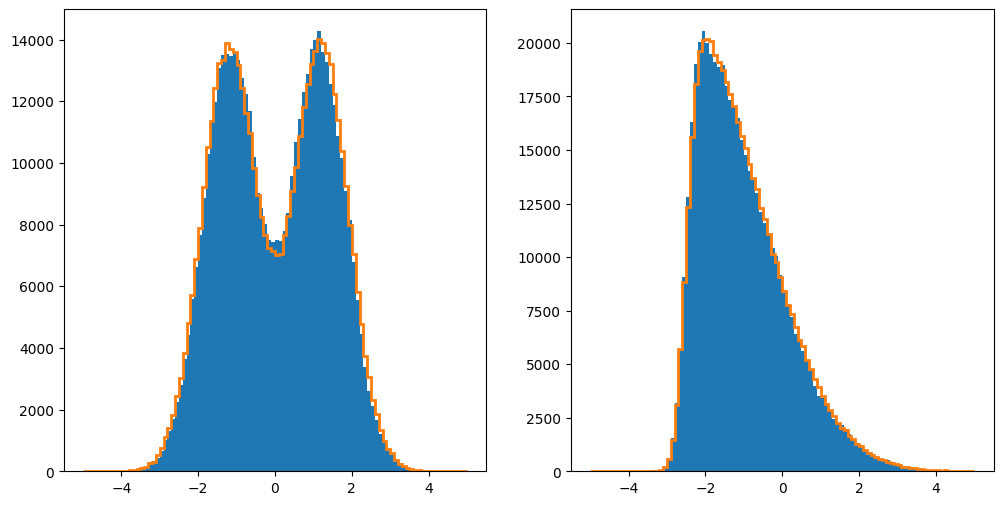

End of epoch 25
epoch 26, step 0/1757, Loss: 3.1370, KL loss: 0.0436
epoch 26, step 200/1757, Loss: 3.1387, KL loss: 0.0436
epoch 26, step 400/1757, Loss: 3.2030, KL loss: 0.0436
epoch 26, step 600/1757, Loss: 3.1834, KL loss: 0.0436
epoch 26, step 800/1757, Loss: 3.1020, KL loss: 0.0436
epoch 26, step 1000/1757, Loss: 3.2207, KL loss: 0.0436
epoch 26, step 1200/1757, Loss: 3.1587, KL loss: 0.0436
epoch 26, step 1400/1757, Loss: 3.1176, KL loss: 0.0436
epoch 26, step 1600/1757, Loss: 3.1116, KL loss: 0.0436
epoch 26, Validation Loss: 3.1434


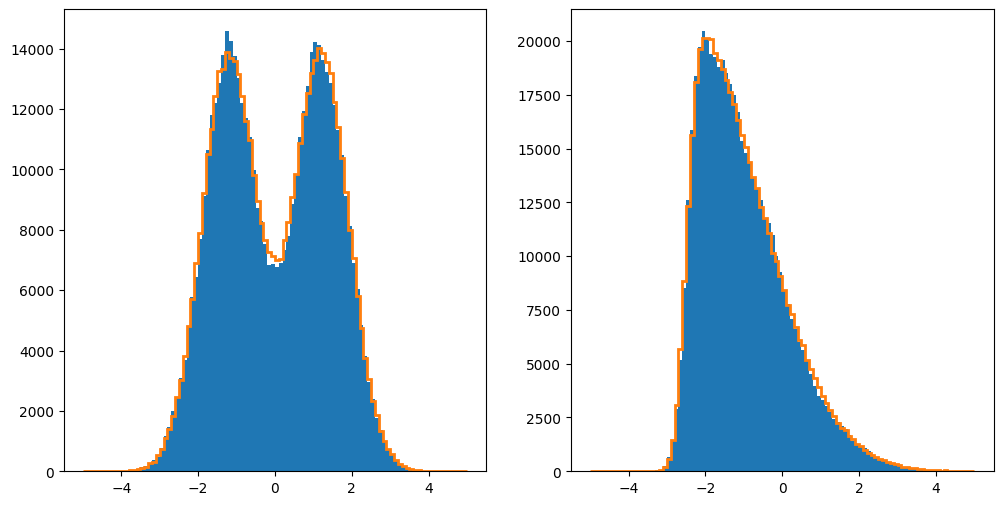

End of epoch 26
epoch 27, step 0/1757, Loss: 3.1602, KL loss: 0.0436
epoch 27, step 200/1757, Loss: 3.1004, KL loss: 0.0436
epoch 27, step 400/1757, Loss: 3.2265, KL loss: 0.0436
epoch 27, step 600/1757, Loss: 3.0263, KL loss: 0.0436
epoch 27, step 800/1757, Loss: 3.1336, KL loss: 0.0436
epoch 27, step 1000/1757, Loss: 3.1177, KL loss: 0.0436
epoch 27, step 1200/1757, Loss: 3.0684, KL loss: 0.0436
epoch 27, step 1400/1757, Loss: 3.0778, KL loss: 0.0436
epoch 27, step 1600/1757, Loss: 3.1507, KL loss: 0.0436
epoch 27, Validation Loss: 3.1464


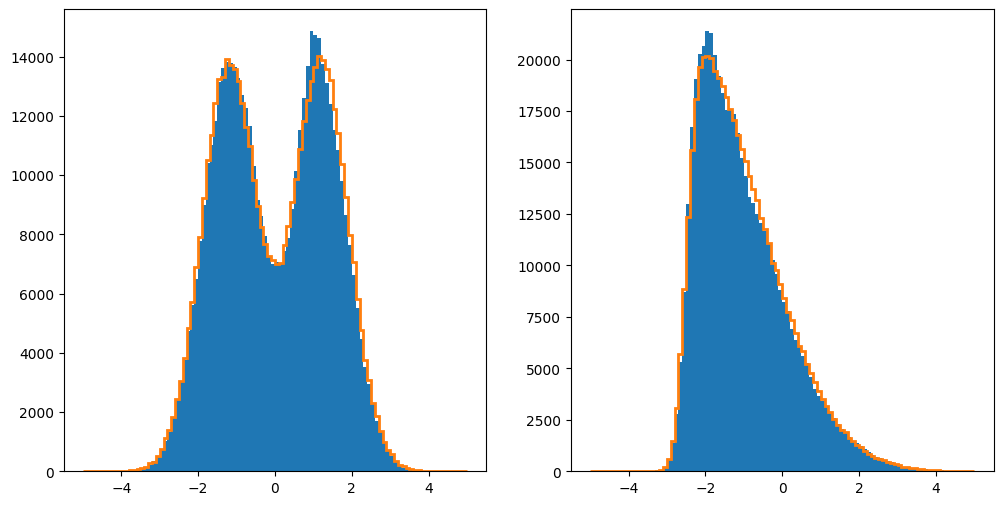

End of epoch 27
epoch 28, step 0/1757, Loss: 3.1826, KL loss: 0.0436
epoch 28, step 200/1757, Loss: 3.1296, KL loss: 0.0436
epoch 28, step 400/1757, Loss: 3.1441, KL loss: 0.0436
epoch 28, step 600/1757, Loss: 3.1942, KL loss: 0.0436
epoch 28, step 800/1757, Loss: 3.1466, KL loss: 0.0436
epoch 28, step 1000/1757, Loss: 3.1864, KL loss: 0.0436
epoch 28, step 1200/1757, Loss: 3.0585, KL loss: 0.0436
epoch 28, step 1400/1757, Loss: 3.0875, KL loss: 0.0436
epoch 28, step 1600/1757, Loss: 3.0703, KL loss: 0.0436
epoch 28, Validation Loss: 3.1305


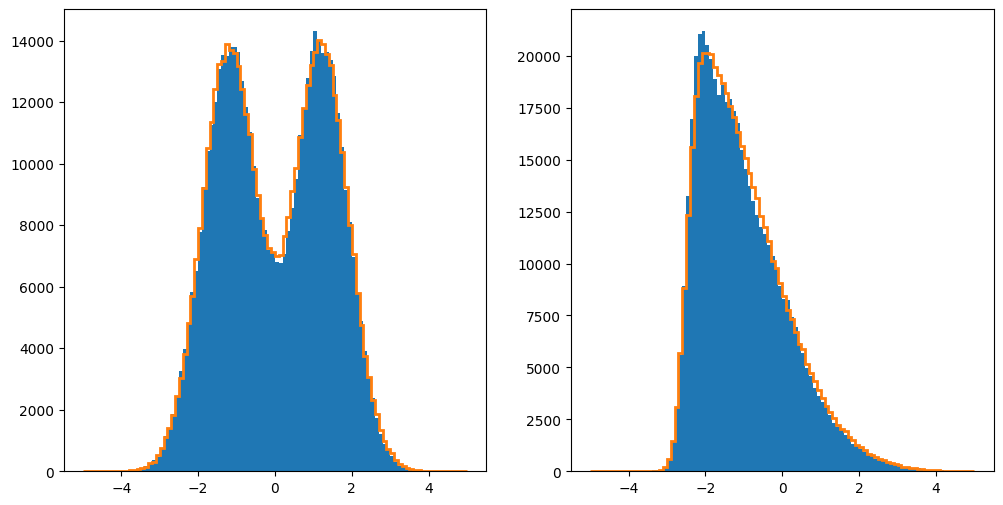

End of epoch 28
epoch 29, step 0/1757, Loss: 3.0266, KL loss: 0.0436
epoch 29, step 200/1757, Loss: 3.2054, KL loss: 0.0436
epoch 29, step 400/1757, Loss: 3.1534, KL loss: 0.0436
epoch 29, step 600/1757, Loss: 3.1258, KL loss: 0.0436
epoch 29, step 800/1757, Loss: 3.1241, KL loss: 0.0436
epoch 29, step 1000/1757, Loss: 3.0778, KL loss: 0.0436
epoch 29, step 1200/1757, Loss: 3.1181, KL loss: 0.0436
epoch 29, step 1400/1757, Loss: 3.1001, KL loss: 0.0436
epoch 29, step 1600/1757, Loss: 3.0325, KL loss: 0.0436
epoch 29, Validation Loss: 3.1272


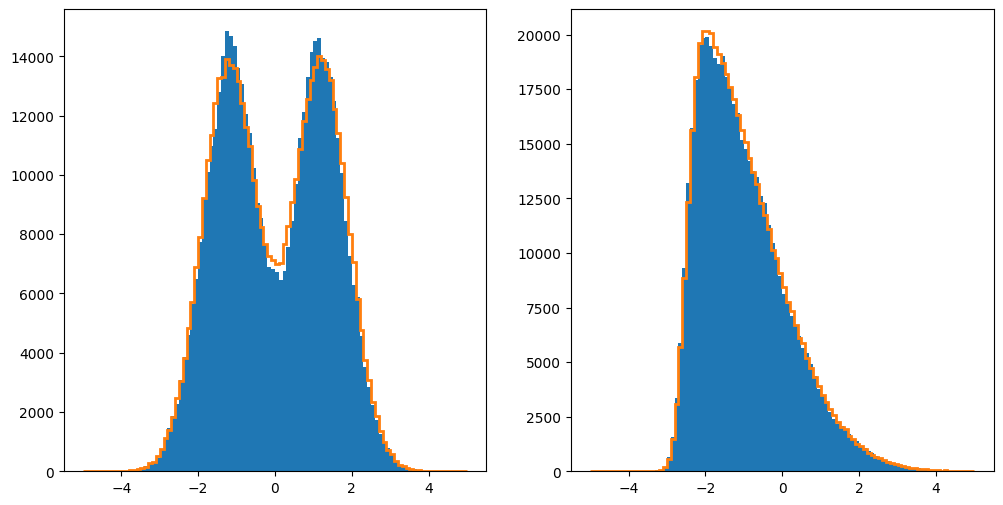

End of epoch 29


In [53]:
model = zuko.flows.NSF(features=2, context=0,  bins= 20,
                                            transforms=2, hidden_features=(64,64,64,64)).to("cuda")
bayes_model = BayesianModel(model, init_logvar=-7.,
                                                include_params=["transform.transforms.*.hyper.6.*"])

optimizer = torch.optim.AdamW(bayes_model.parameters(), lr = 5e-5)

batch_size = 256
nepochs = 30
steps_per_epoch = len(train_ds) // batch_size
total_steps = nepochs * steps_per_epoch
warmup_steps = steps_per_epoch
scheduler = LinearWarmupCosineDecay(optimizer, warmup_steps, total_steps)

flow, val_losses = train_flow(bayes_model,  train_loader, val_loader,  optimizer, scheduler,  batch_size = batch_size,
                             epochs=nepochs,   
                             steps=steps_per_epoch,   niter_print=200)

# Save the model
#torch.save(model.state_dict(), config[model]['model']['name'])


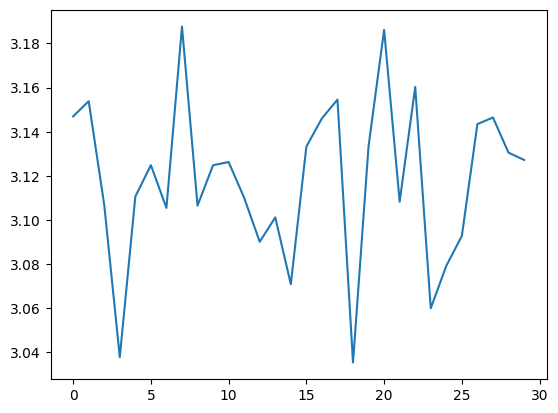

In [54]:
plt.plot([v.cpu() for v in  val_losses])

In [55]:
torch.save(bayes_model.state_dict(), "bayes_model_40bins_64x4.pt")

In [7]:
model = zuko.flows.NSF(features=2, context=0,  bins= 20,
                                            transforms=2, hidden_features=(64,64,64)).to("cuda")
bayes_model = BayesianModel(model, init_logvar=-9.)
bayes_model.load_state_dict(torch.load("bayes_model_v2.pt"))

<All keys matched successfully>

In [56]:
ys = []
for i in range(40):
    with torch.no_grad():
            bmodel = bayes_model.sample_model()
            y = bmodel().rsample((len(target_data),))
            ys.append(y.unsqueeze(0))

Ys = torch.cat(ys, dim=0)

In [57]:
def bayesian_histogram(data, bins, density=False, mask = None):
    if mask is None:
        if isinstance(data, list):
            histograms = np.stack([np.histogram(d, bins=bins, density=density)[0] for d in data], axis=0)
        else:
            histograms = np.stack([np.histogram(data[i,:], bins=bins, density=density)[0] for i in range(data.shape[0])], axis=0)
    else:
        if isinstance(data, list):
            histograms = np.stack([np.histogram(d[mask[i]], bins=bins, density=density)[0] for i, d in enumerate(data)], axis=0)
        else:
            histograms = np.stack([np.histogram(data[i,:][mask[i]], bins=bins, density=density)[0] for i in range(data.shape[0])], axis=0)
    return np.mean(histograms, axis=0), np.std(histograms, axis=0)


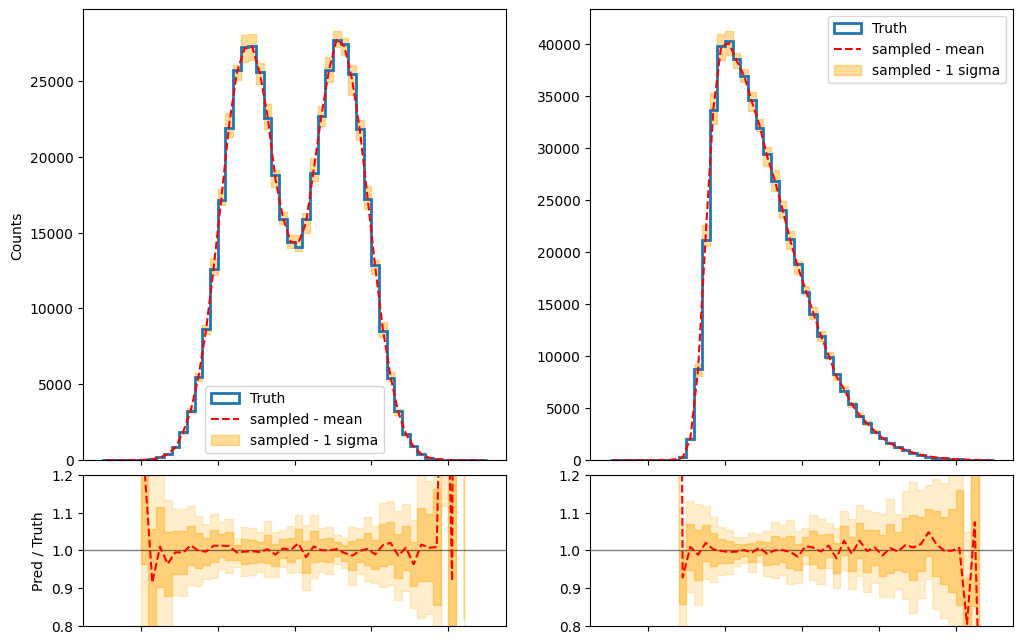

In [62]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Set up the figure with GridSpec
# 2 rows, 2 columns. Row 0 is 3x taller than Row 1.
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], hspace=0.05)

# --- LEFT COLUMN (Index 0) ---

# 1. Main Plot (Top Left)
ax0_main = plt.subplot(gs[0, 0])
N0, bins0, _ = ax0_main.hist(target_data[:,0], bins=50, range=(-5,5), 
                             histtype="step", linewidth=2, label="Truth")

mean0, stds0 = bayesian_histogram(Ys[:,:,0].cpu(), bins0)
bins_centers0 =  (bins0[:-1] + bins0[1:]) / 2

ax0_main.plot(bins_centers0, mean0, alpha=1, linestyle="--", color="red", label="sampled - mean")
ax0_main.fill_between(bins0[:-1], mean0 - stds0, mean0 + stds0, alpha=0.4, step="post",
                      color="orange", label="sampled - 1 sigma")

ax0_main.legend()
ax0_main.set_xticklabels([]) # Hide x-labels for the top plot
ax0_main.set_ylabel("Counts")

# 2. Ratio Plot (Bottom Left)
ax0_ratio = plt.subplot(gs[1, 0], sharex=ax0_main)

# Calculate Ratio (Mean / N)
# Avoid division by zero by using a mask or replacing zeros with NaN
safe_N0 = N0.copy()
safe_N0[safe_N0 == 0] = np.nan 

ratio0 = mean0 / safe_N0
ratio_std0 = stds0 / safe_N0

# Reference line at 1
ax0_ratio.axhline(1, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Ratio Mean
ax0_ratio.plot(bins_centers0, ratio0, color="red", linestyle="--")

# 1 Sigma Band (Ratio)
ax0_ratio.fill_between(bins0[:-1], ratio0 - ratio_std0, ratio0 + ratio_std0, 
                       alpha=0.4, step="post", color="orange")

# 2 Sigma Band (Ratio)
ax0_ratio.fill_between(bins0[:-1], ratio0 - 2*ratio_std0, ratio0 + 2*ratio_std0, 
                       alpha=0.2, step="post", color="orange")

ax0_ratio.set_ylabel("Pred / Truth")
ax0_ratio.set_ylim(0.8, 1.2) # Adjust limits as needed based on your data


# --- RIGHT COLUMN (Index 1) ---

# 3. Main Plot (Top Right)
ax1_main = plt.subplot(gs[0, 1])
N1, bins1, _ = ax1_main.hist(target_data[:,1], bins=50, range=(-5,5), 
                             histtype="step", linewidth=2, label="Truth")

mean1, stds1 = bayesian_histogram(Ys[:,:,1].cpu(), bins1)
bins_centers1 = (bins1[:-1] + bins1[1:]) / 2

ax1_main.plot(bins_centers1, mean1, alpha=1, linestyle="--", color="red", label="sampled - mean")
ax1_main.fill_between(bins0[:-1], mean1 - stds1, mean1 + stds1, alpha=0.4, step="post",
                      color="orange", label="sampled - 1 sigma")

ax1_main.legend()
ax1_main.set_xticklabels([]) # Hide x-labels for the top plot

# 4. Ratio Plot (Bottom Right)
ax1_ratio = plt.subplot(gs[1, 1], sharex=ax1_main)

# Calculate Ratio
safe_N1 = N1.copy()
safe_N1[safe_N1 == 0] = np.nan

ratio1 = mean1 / safe_N1
ratio_std1 = stds1 / safe_N1

# Reference line at 1
ax1_ratio.axhline(1, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Ratio Mean
ax1_ratio.plot(bins_centers1, ratio1, color="red", linestyle="--")

# 1 Sigma Band (Ratio)
ax1_ratio.fill_between(bins0[:-1], ratio1 - ratio_std1, ratio1 + ratio_std1, 
                       alpha=0.4, step="post", color="orange")

# 2 Sigma Band (Ratio)
ax1_ratio.fill_between(bins0[:-1], ratio1 - 2*ratio_std1, ratio1 + 2*ratio_std1, 
                       alpha=0.2, step="post", color="orange")

ax1_ratio.set_ylim(0.8, 1.2) # Adjust limits as needed

plt.show()

(array([2.000e+00, 9.000e+00, 2.500e+01, 3.400e+01, 4.800e+01, 7.200e+01,
        7.600e+01, 8.300e+01, 1.170e+02, 1.290e+02, 9.600e+01, 1.190e+02,
        9.300e+01, 1.080e+02, 1.070e+02, 1.040e+02, 9.100e+01, 1.190e+02,
        9.500e+01, 1.030e+02, 1.370e+02, 1.050e+02, 1.060e+02, 1.070e+02,
        1.200e+02, 9.400e+01, 1.180e+02, 1.090e+02, 1.200e+02, 8.400e+01,
        7.800e+01, 1.000e+02, 1.040e+02, 7.800e+01, 8.100e+01, 1.010e+02,
        8.700e+01, 9.100e+01, 1.010e+02, 9.800e+01, 9.800e+01, 9.400e+01,
        1.120e+02, 1.310e+02, 1.170e+02, 1.360e+02, 1.580e+02, 1.820e+02,
        2.670e+02, 3.376e+03]),
 array([-7.17584515, -7.14438677, -7.11292839, -7.08147001, -7.05001163,
        -7.01855326, -6.98709488, -6.9556365 , -6.92417812, -6.89271975,
        -6.86126137, -6.82980299, -6.79834461, -6.76688623, -6.73542786,
        -6.70396948, -6.6725111 , -6.64105272, -6.60959435, -6.57813549,
        -6.54667759, -6.51521873, -6.48376083, -6.45230198, -6.42084408,
        -6.

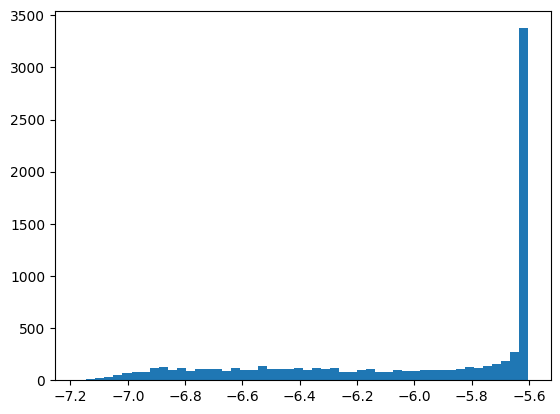

In [60]:
plt.hist(torch.cat([ p.flatten() for p  in  bayes_model.logvars.values()]).cpu().detach().numpy(), bins=50)

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], shape=(100, 100)),
 array([-4.955995  , -4.8586445 , -4.761294  , -4.6639433 , -4.5665927 ,
        -4.469242  , -4.3718915 , -4.274541  , -4.177191  , -4.0798397 ,
        -3.9824893 , -3.885139  , -3.7877884 , -3.6904378 , -3.5930872 ,
        -3.4957366 , -3.398386  , -3.3010354 , -3.2036848 , -3.1063342 ,
        -3.0089836 , -2.9116333 , -2.8142827 , -2.716932  , -2.6195815 ,
        -2.5222309 , -2.4248803 , -2.3275297 , -2.2301793 , -2.1328287 ,
        -2.035478  , -1.9381275 , -1.8407769 , -1.7434263 , -1.6460757 ,
        -1.5487251 , -1.4513745 , -1.3540242 , -1.2566736 , -1.159323  ,
        -1.0619724 , -0.9646218 , -0.8672714 , -0.7699208 , -0.6725702 ,
        -0.57521963, -0.47786903, -0.380

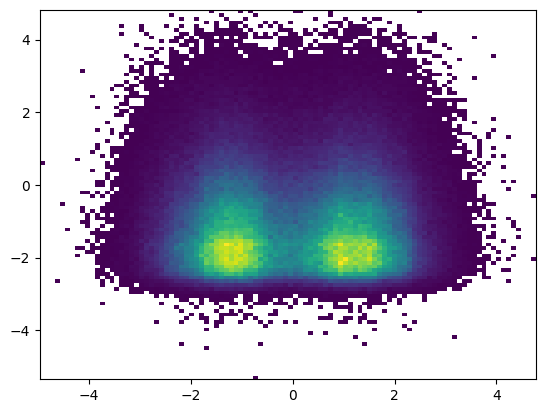

In [15]:
plt.hist2d(Ys[0][:,0].cpu(), Ys[0][:,1].cpu(), bins=100, cmin=1)